## import packages

In [1]:
%matplotlib inline

#traditional import method 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('xtick', labelsize = 18)                  #use 18 point font for numbering on x axis
mpl.rc('ytick', labelsize = 18)                  #use 18 point font for numbering on y axis

In [2]:
import numpy as np # if you use this, 'numpy' is replaced with the abbreviation 'np'

In [3]:
from scipy.optimize import curve_fit  # import nonlinear curve fitting routine
from scipy.stats import chi2          # 'chi-square' goodness of fit calculation

## import data

In [4]:
file_name = 'Calibration_650nm.csv'               # replace with the name of your csv data file

#file_folder = ''                                 # use this if your data file is in the same folder as your python program

file_folder = '/Users/nfortune/data/'              # use this if data file is in a folder called 'data' 
                                                  # inside the folder 'nfortune' within the 'Users' directory 
                                                  # such as when using the Jupyter webserver jove.smith.edu
                                                  # this is called 'absolute addressing'

#file_folder = 'data_subfolder/'                  # you can use this if data file is in a _subfolder_ called 'data_subfolder'
                                                  # this is called 'relative addressing'
data_file = file_folder + file_name

angle, V_pd, V_pd_error  = np.loadtxt(data_file, delimiter = ',', skiprows = 1, usecols = (0, 1, 2), unpack = True)

In [5]:
theta = angle * np.pi / 180                      # convert values in angle array to radians 

## define mathematical model

In [6]:
def polarization_model( phi_array, V_0, phi_0, V_1): # variation of light intensity with  relative polarizer angle
    return V_0 * (1 + np.cos(2 * (phi_array - phi_0)))/2 + V_1

In [7]:
def photodiode_error(phi_array, delta_V_0, delta_phi, delta_V_1, V_0, phi_0):  #calculate delta_V_pd
    V_0_error_sq= (delta_V_0 / V_0)**2 * (np.cos(phi_array - phi_0))**4
    phi_error_sq = (delta_phi)**2 * (2 * np.cos(phi_array- phi_0) * np.sin(phi_array - phi_0))**2
    V_1_error_sq = (delta_V_1 / V_0)**2 
    fractional_error = np.sqrt(V_0_error_sq + V_1_error_sq + phi_error_sq)
    return fractional_error * V_0

## initial values

In [8]:
# measured uncertainties
delta_V0 = 0.020           # mV, after averaging
delta_V1 = 0.014           # mV, after averaging
delta_theta = 0.5 * np.pi / 180  # 0.5 degrees, in radians

In [9]:
# initial guess for polarization models 
V0 = 30.0    #initial guess, in mV
V1 = 0.02    #initial guess, in mV

theta0 = -2.0 * np.pi / 180   #initial guess for offset angle of 2 degree, in radians

In [10]:
initial_guess = np.array([V0, theta0, V1])
initial_error = np.array([delta_V0, delta_theta, delta_V1])
old_fit = np.copy(initial_guess)

## curve fitting of model to data

### initial fit

In [11]:
estimated_error = photodiode_error(theta, delta_V0, delta_theta, delta_V1, V0, theta0)

fit, covariance = curve_fit(polarization_model, theta, V_pd, 
                            p0 = initial_guess, 
                            sigma = estimated_error, absolute_sigma = True)

error = np.sqrt(np.diag(covariance))

print(old_fit)
print(fit)

old_fit = np.copy(fit)

V_pd_model = polarization_model(theta, fit[0], fit[1], fit[2])
residual = V_pd - V_pd_model

data_uncertainty = photodiode_error(theta, delta_V0, delta_theta, delta_V1, fit[0], fit[1])

chisq = sum((residual/ data_uncertainty))**2
degrees_of_freedom = len(residual) - len(initial_guess)
reduced_chisq = chisq / degrees_of_freedom  # this should be close to one
CDF = chi2.cdf(chisq, degrees_of_freedom)   # this should be close to 50 percent

print('chi-square         = ',chisq)
print('degrees of freedom = ',degrees_of_freedom)
print('reduced chi-square = ',reduced_chisq)
print('fractional probability of chisq ≤', chisq, 'for ', degrees_of_freedom, 'dof is', CDF)

[  3.00000000e+01  -3.49065850e-02   2.00000000e-02]
[  3.26313779e+01  -2.02784351e-02   2.30194510e-02]
chi-square         =  10.8374831295
degrees of freedom =  22
reduced chi-square =  0.492612869524
fractional probability of chisq ≤ 10.8374831295 for  22 dof is 0.0230094380387


### recursive fit
repeat until get self-consistent result for V0

In [12]:
estimated_error = data_uncertainty

fit, covariance = curve_fit(polarization_model, theta, V_pd, 
                            p0 = initial_guess, 
                            sigma = estimated_error, absolute_sigma = True)

error = np.sqrt(np.diag(covariance))

print(old_fit)
print(fit)

old_fit = np.copy(fit)

V_pd_model = polarization_model(theta, fit[0], fit[1], fit[2])
residual = V_pd - V_pd_model

data_uncertainty = photodiode_error(theta, delta_V0, delta_theta, delta_V1, fit[0], fit[1])

chisq = sum((residual/ data_uncertainty))**2
degrees_of_freedom = len(residual) - len(initial_guess)
reduced_chisq = chisq / degrees_of_freedom  # this should be close to one
CDF = chi2.cdf(chisq, degrees_of_freedom)   # this should be close to 50 percent

print('chi-square         = ',chisq)
print('degrees of freedom = ',degrees_of_freedom)
print('reduced chi-square = ',reduced_chisq)
print('fractional probability of chisq ≤', chisq, 'for ', degrees_of_freedom, 'dof is', CDF)

[  3.26313779e+01  -2.02784351e-02   2.30194510e-02]
[  3.26290079e+01  -2.01610463e-02   2.23048873e-02]
chi-square         =  15.2568093664
degrees of freedom =  22
reduced chi-square =  0.693491334838
fractional probability of chisq ≤ 15.2568093664 for  22 dof is 0.149016787641


In [13]:
estimated_error = data_uncertainty

fit, covariance = curve_fit(polarization_model, theta, V_pd, 
                            p0 = initial_guess, 
                            sigma = estimated_error, absolute_sigma = True)

error = np.sqrt(np.diag(covariance))

print(old_fit)
print(fit)

old_fit = np.copy(fit)

V_pd_model = polarization_model(theta, fit[0], fit[1], fit[2])
residual = V_pd - V_pd_model

data_uncertainty = photodiode_error(theta, delta_V0, delta_theta, delta_V1, fit[0], fit[1])

chisq = sum((residual/ data_uncertainty))**2
degrees_of_freedom = len(residual) - len(initial_guess)
reduced_chisq = chisq / degrees_of_freedom  # this should be close to one
CDF = chi2.cdf(chisq, degrees_of_freedom)   # this should be close to 50 percent

print('chi-square         = ',chisq)
print('degrees of freedom = ',degrees_of_freedom)
print('reduced chi-square = ',reduced_chisq)
print('fractional probability of chisq ≤', chisq, 'for ', degrees_of_freedom, 'dof is', CDF)

[  3.26290079e+01  -2.01610463e-02   2.23048873e-02]
[  3.26289975e+01  -2.01600429e-02   2.23017148e-02]
chi-square         =  15.2779956829
degrees of freedom =  22
reduced chi-square =  0.694454349221
fractional probability of chisq ≤ 15.2779956829 for  22 dof is 0.149965947887


In [14]:
estimated_error = data_uncertainty

fit, covariance = curve_fit(polarization_model, theta, V_pd, 
                            p0 = initial_guess, 
                            sigma = estimated_error, absolute_sigma = True)

error = np.sqrt(np.diag(covariance))

print(old_fit)
print(fit)

old_fit = np.copy(fit)

V_pd_model = polarization_model(theta, fit[0], fit[1], fit[2])
residual = V_pd - V_pd_model

data_uncertainty = photodiode_error(theta, delta_V0, delta_theta, delta_V1, fit[0], fit[1])

chisq = sum((residual/ data_uncertainty))**2
degrees_of_freedom = len(residual) - len(initial_guess)
reduced_chisq = chisq / degrees_of_freedom  # this should be close to one
CDF = chi2.cdf(chisq, degrees_of_freedom)   # this should be close to 50 percent

print('chi-square         = ',chisq)
print('degrees of freedom = ',degrees_of_freedom)
print('reduced chi-square = ',reduced_chisq)
print('fractional probability of chisq ≤', chisq, 'for ', degrees_of_freedom, 'dof is', CDF)

[  3.26289975e+01  -2.01600429e-02   2.23017148e-02]
[  3.26289974e+01  -2.01600389e-02   2.23016636e-02]
chi-square         =  15.2782032095
degrees of freedom =  22
reduced chi-square =  0.694463782251
fractional probability of chisq ≤ 15.2782032095 for  22 dof is 0.149975260618


In [15]:
estimated_error = data_uncertainty

fit, covariance = curve_fit(polarization_model, theta, V_pd, 
                            p0 = initial_guess, 
                            sigma = estimated_error, absolute_sigma = True)

error = np.sqrt(np.diag(covariance))

print(old_fit)
print(fit)

old_fit = np.copy(fit)

V_pd_model = polarization_model(theta, fit[0], fit[1], fit[2])
residual = V_pd - V_pd_model

data_uncertainty = photodiode_error(theta, delta_V0, delta_theta, delta_V1, fit[0], fit[1])

chisq = sum((residual/ data_uncertainty))**2
degrees_of_freedom = len(residual) - len(initial_guess)
reduced_chisq = chisq / degrees_of_freedom  # this should be close to one
CDF = chi2.cdf(chisq, degrees_of_freedom)   # this should be close to 50 percent

print('chi-square         = ',chisq)
print('degrees of freedom = ',degrees_of_freedom)
print('reduced chi-square = ',reduced_chisq)
print('fractional probability of chisq ≤', chisq, 'for ', degrees_of_freedom, 'dof is', CDF)

[  3.26289974e+01  -2.01600389e-02   2.23016636e-02]
[  3.26289974e+01  -2.01600294e-02   2.23017054e-02]
chi-square         =  15.2781646011
degrees of freedom =  22
reduced chi-square =  0.694462027322
fractional probability of chisq ≤ 15.2781646011 for  22 dof is 0.149973528047


## graph results

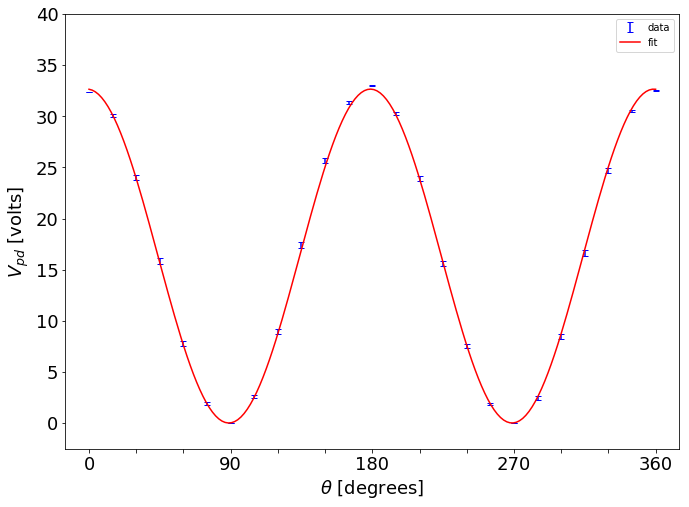

In [16]:
plt.figure(figsize = (11,8))                  #specify figure size as 7 x 5 inches
                                             #for default size, type plt.figure() 
                                             
plt.xlabel(r"$\theta$ [degrees]", fontsize = 18) #label axis (using LaTeX commands)
plt.ylabel(r"$V_{pd}$ [volts]", fontsize = 18)   #use 18 point font for label text

# plot the data as before in blue
plt.errorbar(angle, V_pd,  
    xerr=None, yerr=V_pd_error, 
    linestyle = 'none', 
    color = 'blue',  
    capsize = 3, capthick = 1, label = "data")

#create curve showing fit to data 
angle_fit = np.linspace(0, 360, 180)
theta_fit = angle_fit * np.pi / 180
V_pd_fit = polarization_model(theta_fit, fit[0], fit[1], fit[2])

#plot the curve fit in red
plt.errorbar(angle_fit, V_pd_fit, xerr = None, yerr = None, color = 'red', label = 'fit' )
plt.xlim(-15, 375)
plt.ylim(-2.5, 40)
plt.xticks([0,   30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360], 
           ('0', '', '', 90,  '',  '', 180,  '',  '', 270,  '',  '', 360))
plt.legend(loc = 'best')
    
plt.show()  


In [17]:
print()
print('V_0     = ','{:.3f}'.format(fit[0]), ' ±', '{:.3f}'.format(error[0]), ' mV')
print('V_1     = ',' {:.3f}'.format(fit[2]), ' ±', '{:.3f}'.format(error[2]), ' mV')
print('theta_0 = ','{:.4f}'.format(fit[1]), '±', '{:.4f}'.format(error[1]), 'radian')
print('        = ','{:.3f}'.format(fit[1]*180/np.pi), ' ±', '{:.3f}'.format(error[1]*180/np.pi), 'degrees')


V_0     =  32.629  ± 0.020  mV
V_1     =   0.022  ± 0.013  mV
theta_0 =  -0.0202 ± 0.0020 radian
        =  -1.155  ± 0.112 degrees
